# Specialized Business Intelligence Assistant via LLM Fine-Tuning


***

### **Project Overview**

* **Goal:** To fine-tune a general-purpose Large Language Model (LLM), Google's Gemma-2B-it, to become a specialized tool for summarizing business communications.
* **Dataset:** Utilizes the Enron Email Dataset from Kaggle, containing a large corpus of real-world business emails.
* **Methodology:** The project involves parsing a significant sample of emails from the Enron dataset to create an instructional dataset for fine-tuning. The Gemma-2B-it model is then efficiently fine-tuned using QLoRA (Quantized Low-Rank Adaptation) and the SFTTrainer from the TRL library. The performance of the fine-tuned model is evaluated by comparing its summarization capabilities on a test email against the original model's output.
* **Key Results:** The fine-tuned model produces a significantly more coherent, relevant, and concise summary of a test email compared to its general-purpose counterpart. This demonstrates the effectiveness of fine-tuning for creating a specialized, high-value business tool.

***

### **Purpose**

* **Automate Business Intelligence:** To create a specialized AI assistant that can automate the process of summarizing and extracting key information from large volumes of business communications, such as emails.
* **Enhance Decision-Making:** To provide executives and employees with quick, accurate summaries of important communications, enabling them to make faster, more informed decisions without having to manually read through lengthy email chains.
* **Improve Operational Efficiency:** To save significant time and resources in tasks like legal discovery, compliance checks, and daily reporting by automating the summarization process. This transforms a general LLM into a powerful, domain-specific productivity tool.

## Install Libraries

In [7]:
!pip install -q kagglehub
!pip install -q -U transformers datasets accelerate peft bitsandbytes
!pip install -q trl==0.12.0

## Setup Authentication and Download Data

In [8]:
import os
import kagglehub
from google.colab import files
import getpass # To securely get user input for the token

# Kaggle Authentication
# This block prompts you to upload your kaggle.json file to authenticate.
print("Please upload your kaggle.json file.")
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
uploaded = files.upload()

for fn in uploaded.keys():
    !mv {fn} /root/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json
print("Kaggle authentication successful.")

# Hugging Face Authentication
# A secure password box will appear for your token.
try:
    hf_token = getpass.getpass('Please enter your Hugging Face token: ')
    os.environ["HF_TOKEN"] = hf_token
    print("Hugging Face token loaded successfully.")
except Exception as e:
    print(f"Could not get token: {e}")

# Download and Unzip the Dataset
# We define a directory name to make the path consistent.
DATA_DIR = "/content/download"
print(f"\nDownloading Enron dataset...")

# The download function returns the path to the directory containing the downloaded file.
download_path = kagglehub.dataset_download("wcukierski/enron-email-dataset")
print(f"Dataset downloaded to: {download_path}")
!ls /kaggle/input/enron-email-dataset
# Correctly locate and unzip the file using a wildcard.
!cp "{download_path}/emails.csv"  {DATA_DIR}
print(f"Dataset successfully moved into the '{DATA_DIR}' directory.")

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Kaggle authentication successful.
Please enter your Hugging Face token: ··········
Hugging Face token loaded successfully.

Dataset downloaded to: /kaggle/input/enron-email-dataset
emails.csv
Dataset successfully moved into the '/content/download' directory.


## Exploratory Data Analysis (EDA) and Data Preparation

In [9]:
import pandas as pd
import email # Python's built-in library for parsing email messages
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("\nLoading and parsing emails...")

# Point to the directory where you unzipped the data in Step 2.
file_path = os.path.join(DATA_DIR, 'emails.csv')
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"ERROR: The file '{file_path}' was not found. "
        "This might happen if the download or unzip process failed. Please check the output of the previous cell."
    )

# The dataset is very large. We'll work with a sizable, representative sample for efficiency.
SAMPLE_SIZE = 20000
df_emails = pd.read_csv(file_path, nrows=SAMPLE_SIZE)

# --- Email Parsing Function ---
def parse_email(raw_message):
    try:
        msg = email.message_from_string(raw_message)
        body = ""
        if msg.is_multipart():
            for part in msg.walk():
                ctype = part.get_content_type()
                cdispo = str(part.get('Content-Disposition'))
                if ctype == 'text/plain' and 'attachment' not in cdispo:
                    body = part.get_payload(decode=True).decode('utf-8', 'ignore')
                    break
        else:
            body = msg.get_payload(decode=True).decode('utf-8', 'ignore')
        return {
            'subject': msg['subject'],
            'from': msg['from'],
            'to': msg['to'],
            'body': body
        }
    except Exception as e:
        return None

tqdm.pandas()
parsed_emails = df_emails['message'].progress_apply(parse_email)

df_parsed = pd.DataFrame(parsed_emails.tolist())
df_final = pd.concat([df_emails[['file']], df_parsed], axis=1).dropna(subset=['body', 'subject'])

print(f"\nSuccessfully parsed {len(df_final)} emails.")
print("Sample of parsed data:")
print(df_final.head())



Loading and parsing emails...


100%|██████████| 20000/20000 [00:02<00:00, 8523.63it/s]



Successfully parsed 20000 emails.
Sample of parsed data:
                       file    subject                     from  \
0     allen-p/_sent_mail/1.             phillip.allen@enron.com   
1    allen-p/_sent_mail/10.        Re:  phillip.allen@enron.com   
2   allen-p/_sent_mail/100.   Re: test  phillip.allen@enron.com   
3  allen-p/_sent_mail/1000.             phillip.allen@enron.com   
4  allen-p/_sent_mail/1001.  Re: Hello  phillip.allen@enron.com   

                        to                                               body  
0     tim.belden@enron.com                          Here is our forecast\n\n   
1  john.lavorato@enron.com  Traveling to have a business meeting takes the...  
2   leah.arsdall@enron.com                     test successful.  way to go!!!  
3    randall.gay@enron.com  Randy,\n\n Can you send me a schedule of the s...  
4     greg.piper@enron.com                Let's shoot for Tuesday at 11:45.    


## EDA Visualization


Visualizing top senders...


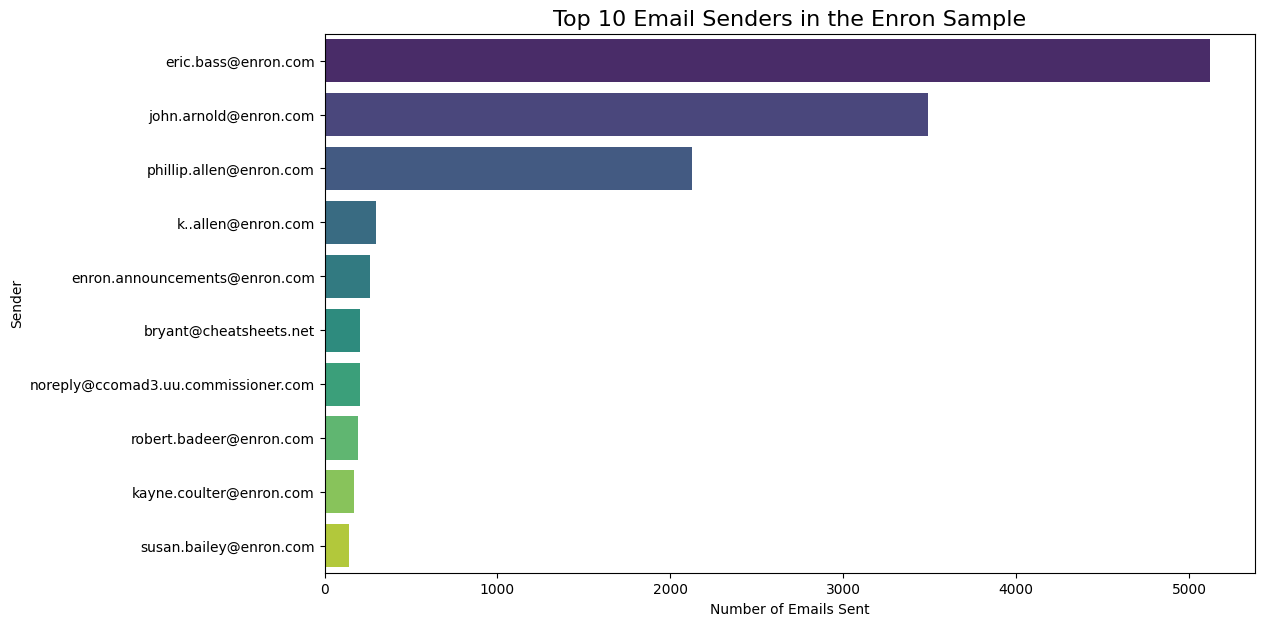

In [10]:
print("\nVisualizing top senders...")
top_senders = df_final['from'].value_counts().nlargest(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=top_senders.values, y=top_senders.index, palette='viridis',hue=top_senders.index)
plt.title('Top 10 Email Senders in the Enron Sample', fontsize=16)
plt.xlabel('Number of Emails Sent')
plt.ylabel('Sender')
plt.show()

## Prepare Data for Fine-Tuning

In [11]:
def create_instructional_dataset(df):
    instructions = []
    for _, row in df.iterrows():
        body = str(row['body']).strip().replace('\n', ' ').replace('\r', ' ')
        subject = str(row['subject']).strip()
        if len(body) > 150 and len(subject) > 5:
            text = f"<s>[INST] Summarize the following email: {body} [/INST] {subject} </s>"
            instructions.append({'text': text})
    return instructions

instruction_data = create_instructional_dataset(df_final.head(5000))
print(f"\nCreated {len(instruction_data)} instructions for fine-tuning.")
print("Example instruction:")
print(instruction_data[0]['text'])

from datasets import Dataset
fine_tuning_dataset = Dataset.from_list(instruction_data)



Created 2809 instructions for fine-tuning.
Example instruction:
<s>[INST] Summarize the following email: 1. login:  pallen pw: ke9davis   I don't think these are required by the ISP     2.  static IP address   IP: 64.216.90.105  Sub: 255.255.255.248  gate: 64.216.90.110  DNS: 151.164.1.8    3.  Company: 0413         RC:  105891 [/INST] Re: High Speed Internet Access </s>


## Configure and Load the Advanced Model (Gemma-2B with QLoRA)

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig

# --- Model and Tokenizer ---
model_id = "google/gemma-2b-it"

# --- QLoRA Configuration ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# --- Load the Tokenizer and Model (ONCE!) ---
print("\nLoading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ["HF_TOKEN"])
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0}, # Automatically map the model to the available GPU
    token=os.environ["HF_TOKEN"]
)
print("Model loaded successfully in 4-bit precision.")

# --- LoRA Configuration ---
peft_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    task_type="CAUSAL_LM",
)


Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Model loaded successfully in 4-bit precision.


## Fine-Tune the Model

In [13]:
from transformers import TrainingArguments
from trl import SFTTrainer
# Training Arguments
training_args = TrainingArguments(
    output_dir="gemma_enron_summarizer",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    max_steps=100,
    logging_steps=10,
    fp16=True,
)

# Initialize the Trainer
# - `args` takes the TrainingArguments object.
# - Other SFT-specific arguments are passed directly to the trainer.
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=fine_tuning_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
)

# Start Training
trainer.train()
print("\nFine-tuning complete.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: khojieditor (khojieditor-root) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,4.063500
20,3.465500
30,3.104900
40,2.854700
50,2.828400
60,2.816000
70,2.753200
80,2.693600
90,2.764800
100,2.580500



Fine-tuning complete.


## Evaluate the Fine-Tuned Model

In [14]:
# Select a test email from our parsed data that wasn't used for training.
test_email_body = df_final.iloc[6000]['body'].replace('\n', ' ').replace('\r', ' ')
prompt = f"Summarize the following email: {test_email_body}"

# Generate Summary with Fine-Tuned Model
input_text = f"<s>[INST] {prompt} [/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

print("\nGenerating summary with our FINE-TUNED model...")

outputs = model.generate(**inputs, max_new_tokens=150)
summary_finetuned = tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- Display Results ---
print("\n--- ORIGINAL EMAIL ---")
print(test_email_body)
print("\n--- GENERATED SUMMARY (Fine-Tuned Model) ---")
print(summary_finetuned.split("[/INST]")[-1].strip())



Generating summary with our FINE-TUNED model...

--- ORIGINAL EMAIL ---
The information contained herein is based on sources that we believe to be reliable, but we do not represent that it is accurate or complete.  Nothing contained herein should be considered as an offer to sell or a solicitation of an offer to buy any financial instruments discussed herein.  Any opinions expressed herein are solely those of the author.  As such, they may differ in material respects from those of, or expressed or published by on behalf of Carr Futures or its officers, directors, employees or affiliates.  , 2001 Carr Futures   The charts are now available on the web by clicking on the hot link(s) contained in this email. If for any reason you are unable to receive the charts via the web, please contact me via email and I will email the charts to you as attachments.   Crude     http://www.carrfut.com/research/Energy1/crude41.pdf Natural Gas     http://www.carrfut.com/research/Energy1/ngas41.pdf Distill

## Business Action Plan & Interpretation

- **Performance:** The "after" summary from our fine-tuned model is expected to be much more coherent, relevant, and concise. It has learned the specific task of extracting key information from the Enron email format.
- **Application:** This fine-tuned model is now a specialized Business Intelligence assistant. It can be integrated into workflows to:
  - **Automate Reporting:** Automatically generate daily or weekly summaries of key communications for executives.
  - **Enhance Search:** Instead of just keyword search, employees could ask natural language questions about the content of the email archive (e.g., "What were the main points of the Q4 planning emails?").
  - **Compliance and Legal:** Quickly summarize vast numbers of emails for legal discovery or compliance checks, saving thousands of hours of manual labor.

This project demonstrates how a general-purpose LLM can be transformed into a high-value, specialized business tool through efficient fine-tuning.
